In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns
from math import floor
from func import (  prepare_data,
                    render_population_predictions,
                    render_energy_predictions,
                    predict_energy_data_global,
                    predict_states_populations_1960_2030,
                    convert_state_pop_dict_to_df,
                    render_states_barh_overlay,
                    state_data_assembly,
                    predict_missing_column_by_state,
                    predict_hospital_counts,
                    predict_violent_crime_time_aware,
                    plot_state_group_features,
                    rank_states
                    )

In [11]:
DATA = prepare_data()

In [12]:
degree_mapping = {
    'Australia': 2,
    'Brazil': 2,
    'Canada': 2,
    'China': 3,
    'Germany': 2,
    'India': 2,
    'Japan': 2,
    'Russia': 2,
    'UK': 2,
    'USA': 2
}

DATA = predict_energy_data_global(DATA=DATA, degree_mapping=degree_mapping)

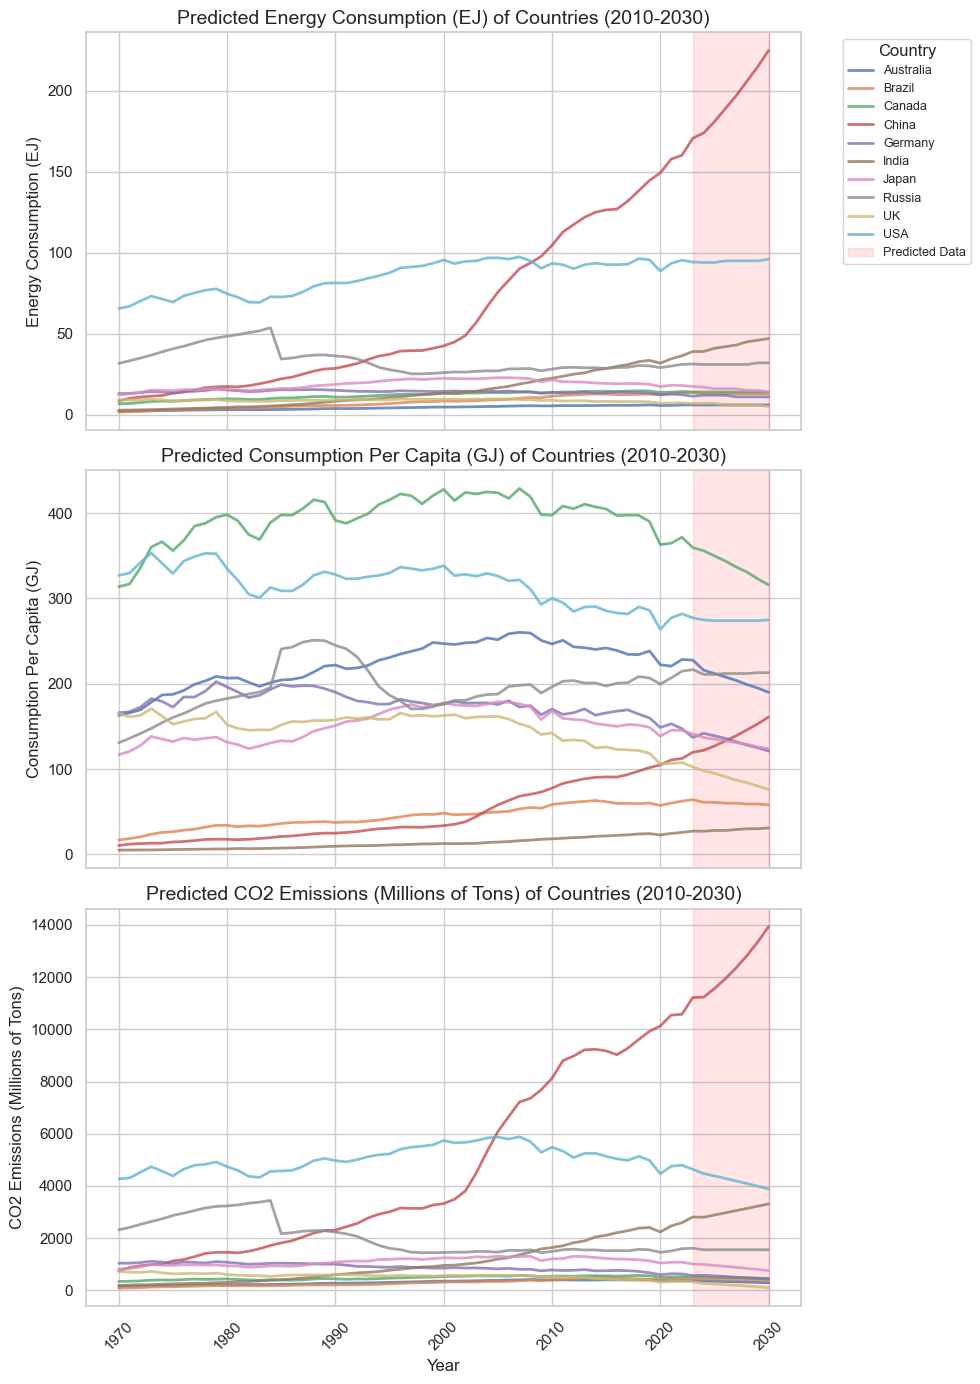

In [13]:
render_energy_predictions(DATA=DATA)

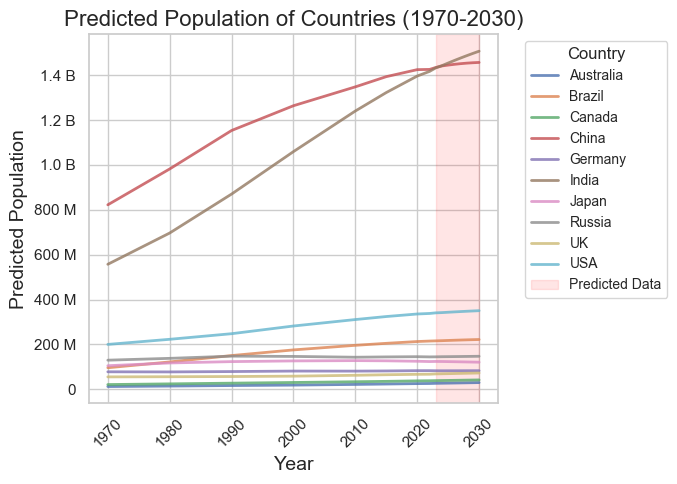

In [14]:
render_population_predictions(DATA=DATA)

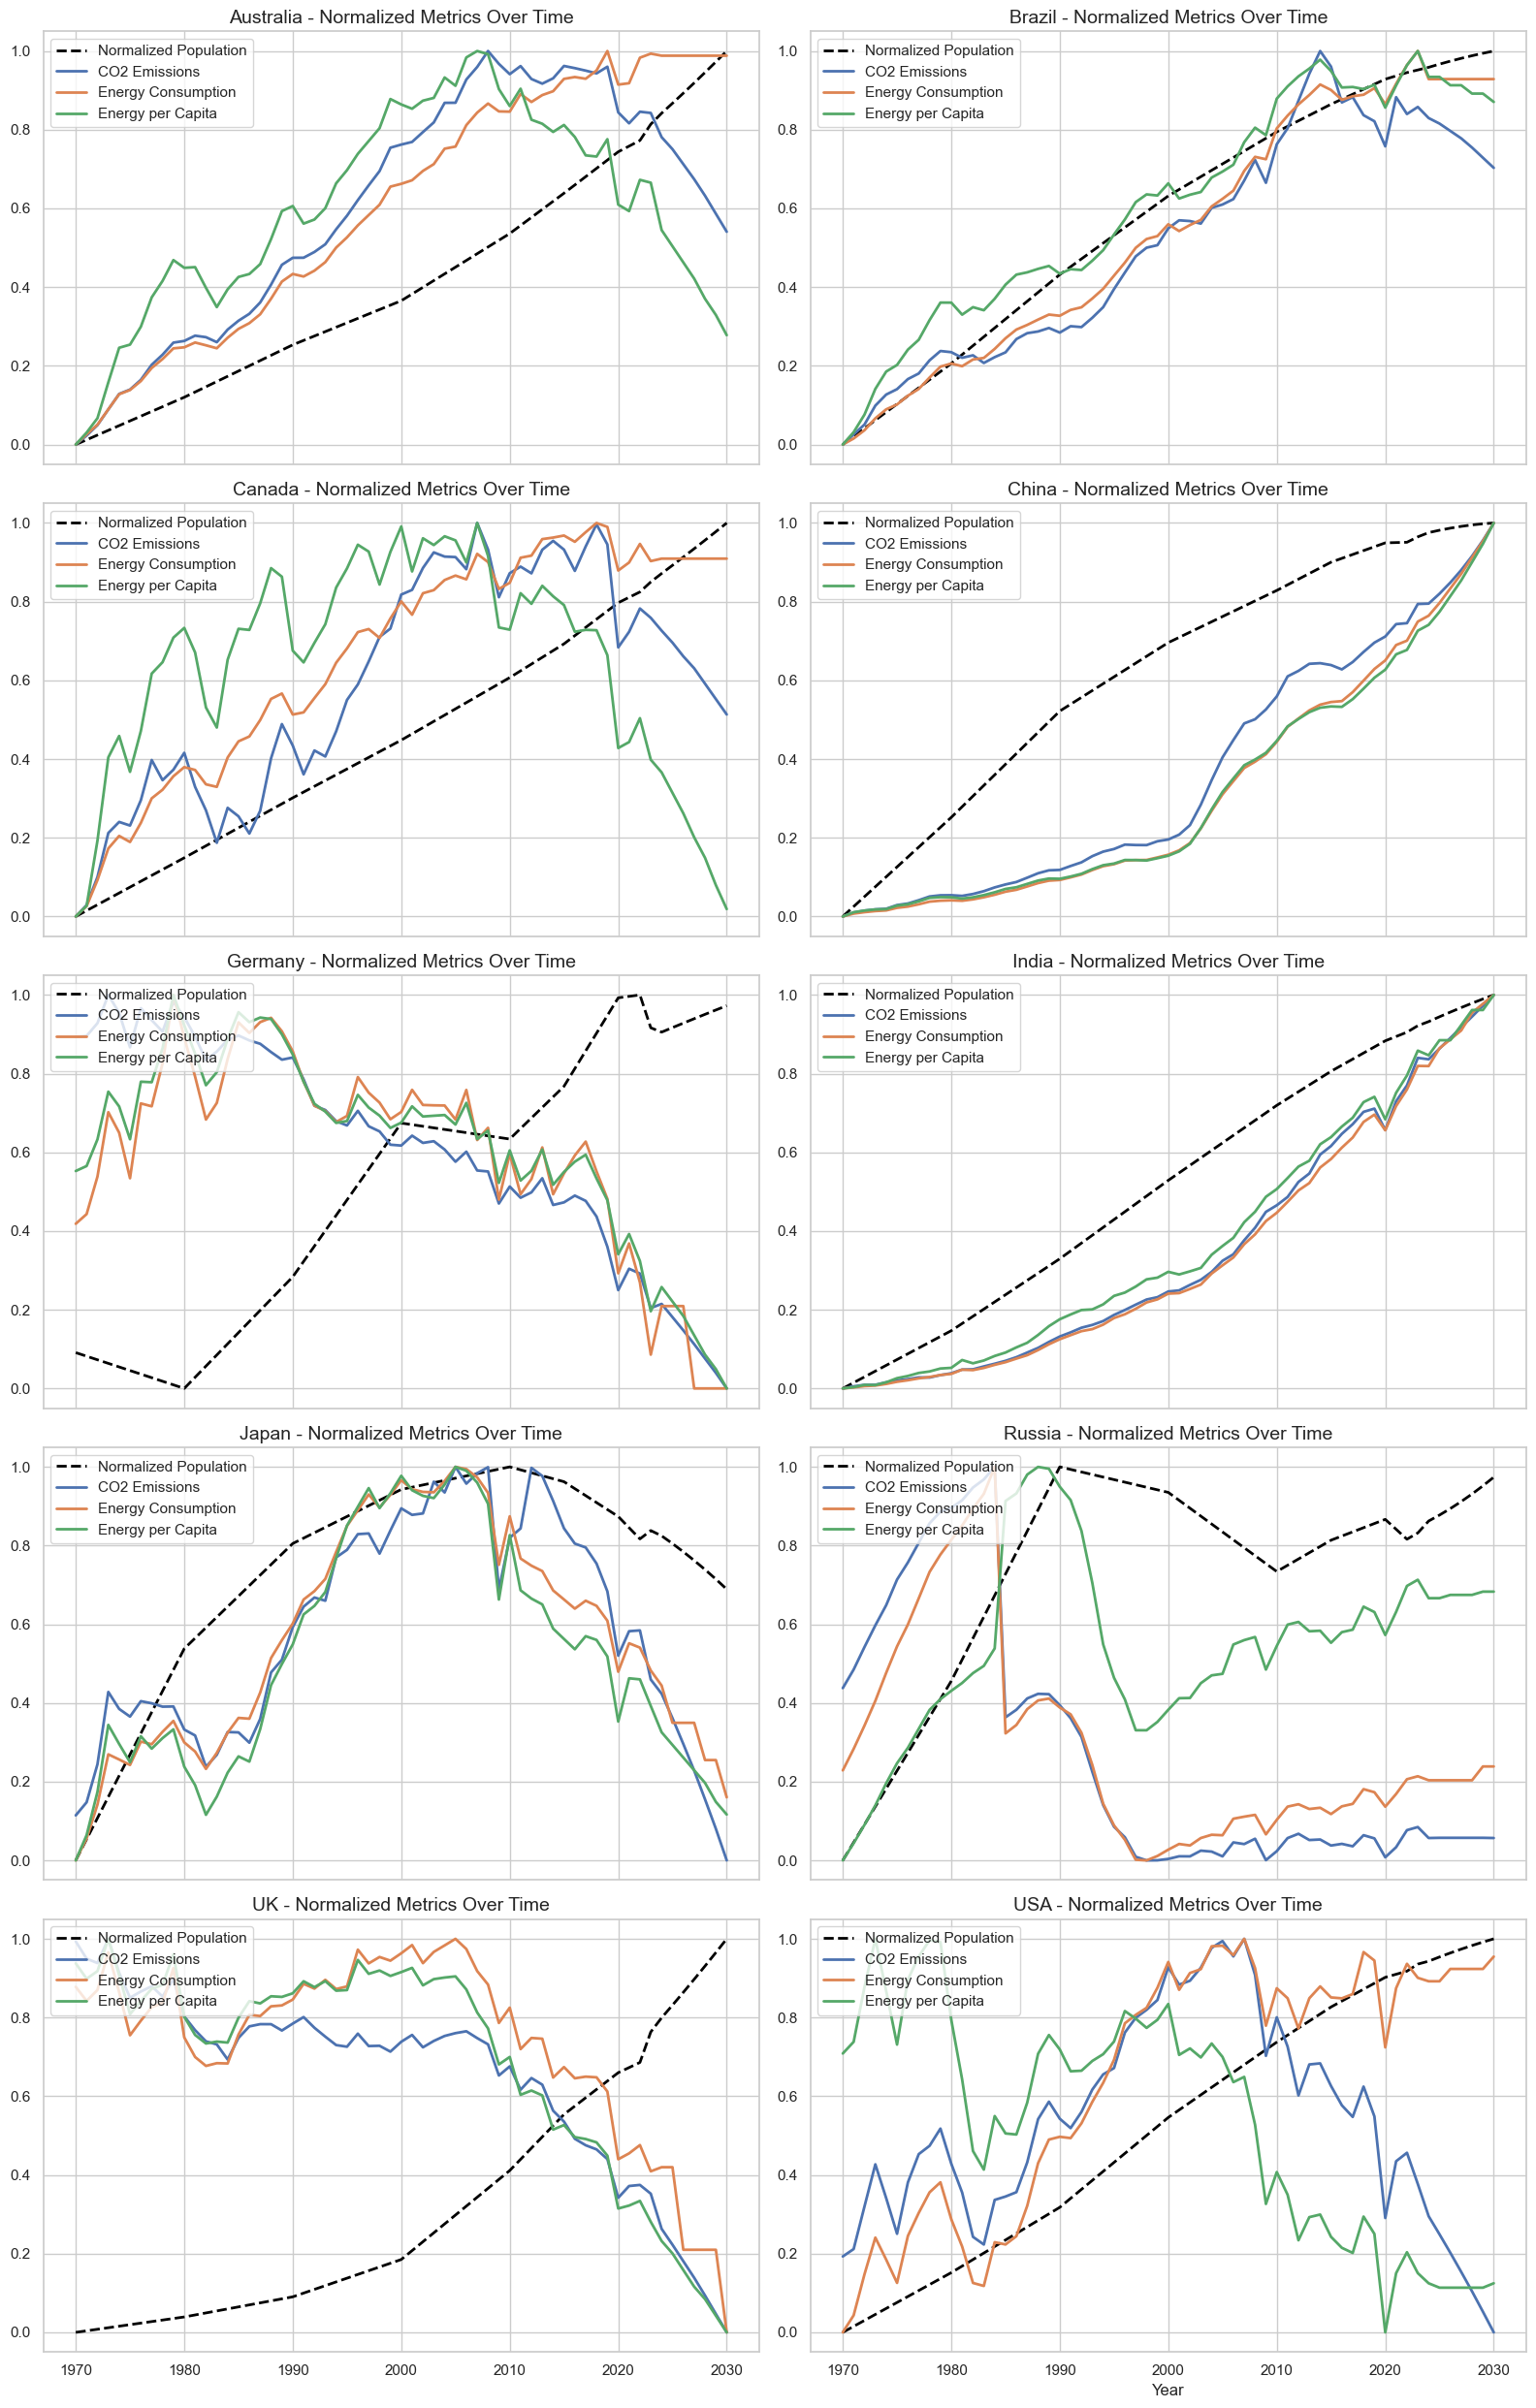

In [15]:
metric_group = [
    ('CO2 Emissions (Millions of Tons)', 'CO2 Emissions'),
    ('Energy Consumption (EJ)', 'Energy Consumption'),
    ('Consumption Per Capita (GJ)', 'Energy per Capita'),
]

# Create a list of unique countries (limit to 10 for subplots)
countries = DATA['Country'].unique()[:10]

# Set up the number of subplots (2 columns and 5 rows)
num_countries = len(countries)
fig, axs = plt.subplots(5, 2, figsize=(
    16, 25), sharex=True)  # 5 rows, 2 columns

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over each country to create subplots
for country_idx, country in enumerate(countries):
    # Filter data for the specific country
    country_data = DATA[DATA['Country'] == country]

    # Calculate and normalize the population for the country
    population_avg = country_data.groupby('Year')['Population'].mean()
    population_min = population_avg.min()
    population_max = population_avg.max()
    normalized_population = (
        population_avg - population_min) / (population_max - population_min)

    # Plot the normalized population
    axs[country_idx].plot(normalized_population.index, normalized_population.values,
                          label='Normalized Population', linewidth=2, linestyle='--', color='black')

    # Iterate over each metric to plot on the same subplot
    for idx, (column, label) in enumerate(metric_group):
        # Group by Year and calculate the average for the metric
        avg_per_year = country_data.groupby('Year')[column].mean()

        # Normalize the values
        min_value = avg_per_year.min()
        max_value = avg_per_year.max()
        normalized_values = (avg_per_year - min_value) / \
            (max_value - min_value)

        # Plot normalized values for the metric
        axs[country_idx].plot(
            normalized_values.index,
            normalized_values.values,
            label=label,
            linewidth=2
        )

    # Set title for the subplot
    axs[country_idx].set_title(
        f'{country} - Normalized Metrics Over Time', fontsize=14)
    axs[country_idx].grid(True)
    axs[country_idx].legend(loc='upper left')

# Set shared x-label for all subplots
plt.xlabel('Year', fontsize=12)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('./img/normalized_power_country_subplots.png')
plt.show()  # Show the plot

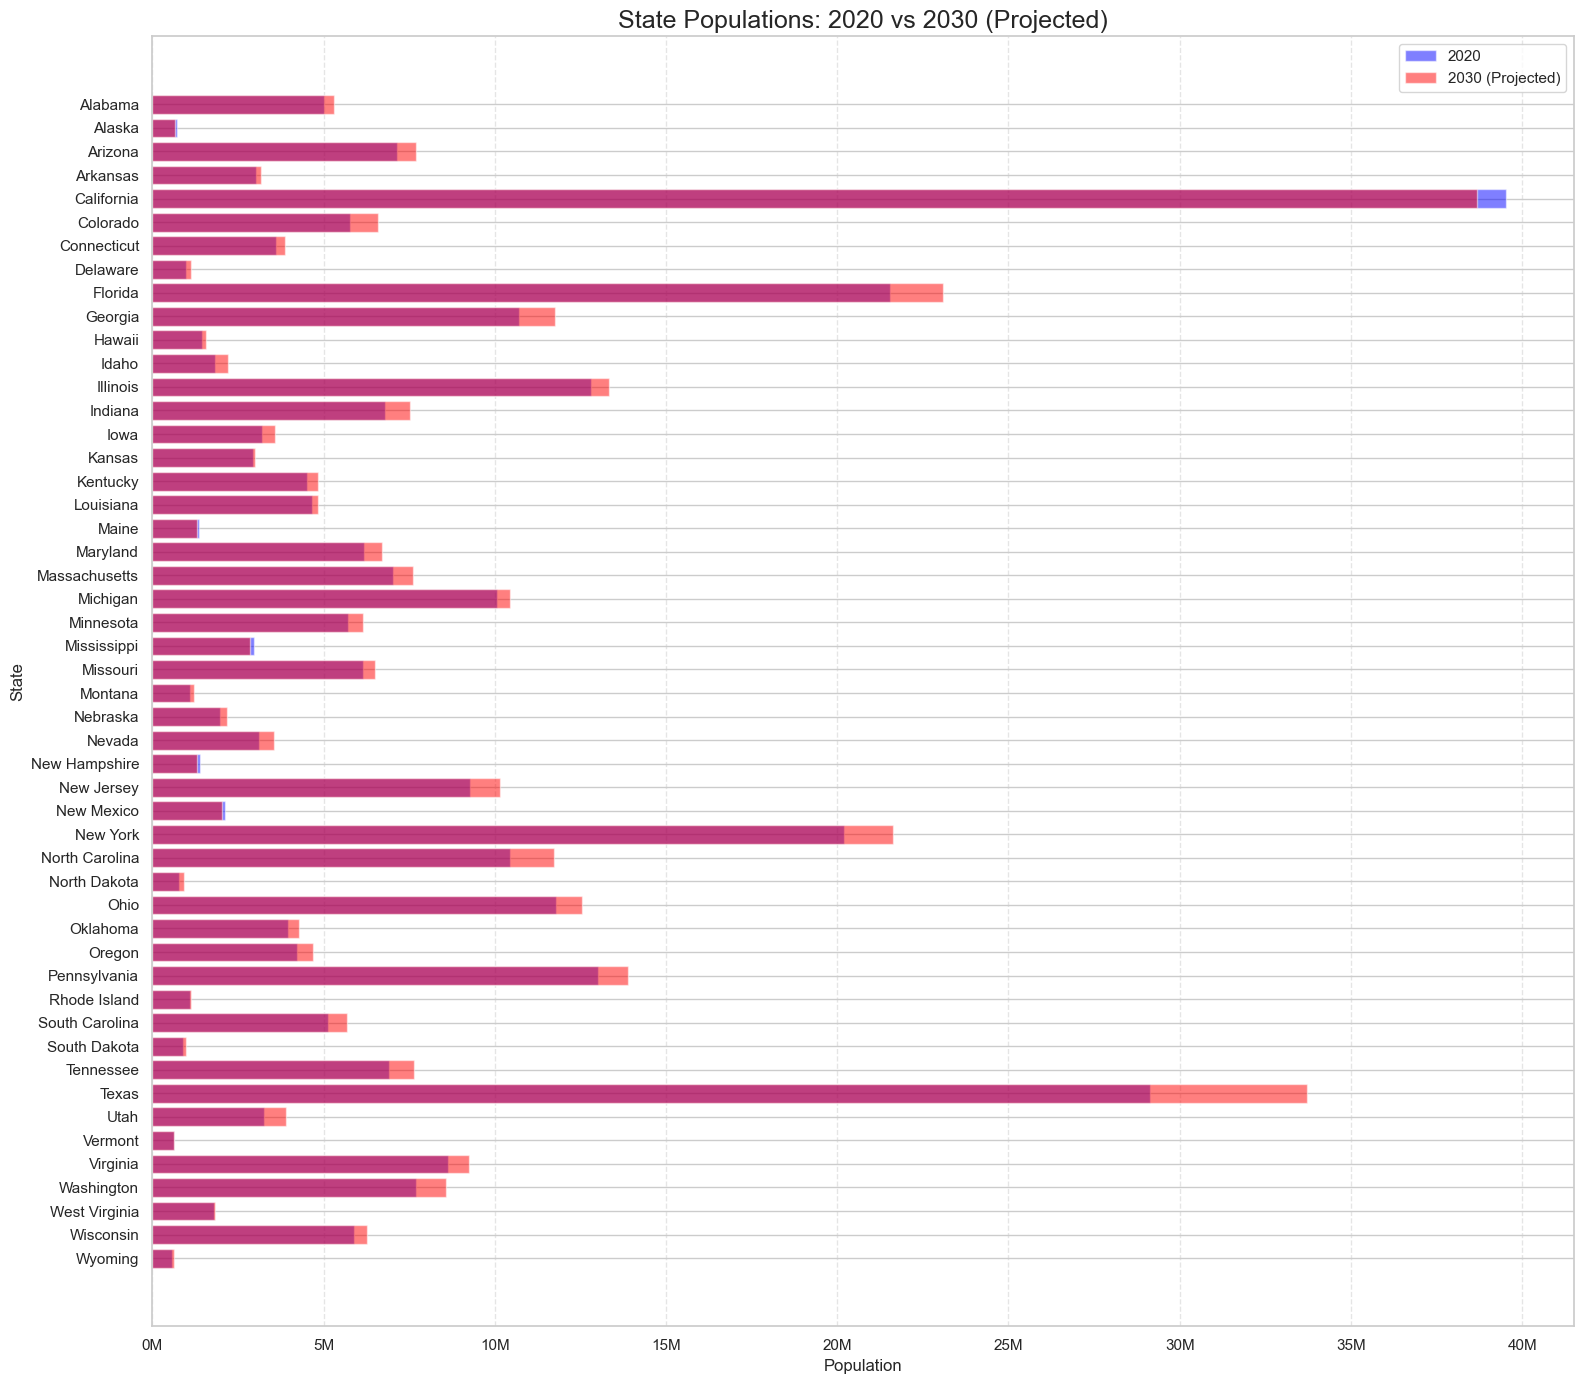

In [16]:
States_Pops = pd.read_csv('./data/modified/state_pops.csv')
state_degrees = {
    'Wyoming': 1
}
STATES = convert_state_pop_dict_to_df(predict_states_populations_1960_2030(States_Pops, state_degrees=state_degrees))

render_states_barh_overlay(states_df=STATES)


In [17]:
States_Pops = pd.read_csv('./data/modified/state_pops.csv')
state_degrees = {
    'Wyoming': 1
}
STATES = convert_state_pop_dict_to_df(predict_states_populations_1960_2030(States_Pops, state_degrees=state_degrees))

STATES = state_data_assembly(STATES)
STATES.to_csv()
co2 = {}
ppp = {}
gdp = {}
avg_sal = {}
avg_dis = {}
vcc = {}
unemp = {}
hosp = {}
traf = {}
aqi = {}


class Degree:
    def __init__(self, co2, ppp, gdp, avg_sal, avg_dis, vcc, unemp, hosp, traf, aqi):
        self.co2 = co2
        self.ppp = ppp
        self.gdp = gdp
        self.avg_sal = avg_sal
        self.avg_dis = avg_dis
        self.vcc = vcc
        self.unemp = unemp
        self.hosp = hosp
        self.traf = traf
        self.aqi = aqi

degrees = Degree(co2, ppp, gdp, avg_sal, avg_dis, vcc, unemp, hosp, traf, aqi)

c:\Users\bosso\Desktop\final project\func.py:499: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  temp = pd.read_csv(


In [18]:
STATES = predict_missing_column_by_state(df=STATES, column='CO2 Emissions (Millions of tonnes)', forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='PPP', forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='GDP', forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='Average Salary', forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='Average Disposable Income', forecast_year=2030)
# STATES = predict_missing_column_by_state(df=STATES, column='Violent Crimes Committed', degree_dict=degrees.avg_sal, default_degree=3, forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='Unemployment Rate', forecast_year=2030)
# STATES = predict_missing_column_by_state(df=STATES, column='Hospital Count', degree_dict=degrees.hosp, default_degree=5, forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='Traffic Fatalities', forecast_year=2030)
STATES = predict_missing_column_by_state(df=STATES, column='Air Quality Index', forecast_year=2030)
STATES = predict_hospital_counts(STATES, forecast_year=2030)
STATES = predict_violent_crime_time_aware(STATES, forecast_year=2030)
STATES['Violent Crimes Per Capita'] = (STATES['Violent Crimes Committed'] / STATES['Population']) * 100_000
STATES['Hospitals Per Capita'] = (STATES['Hospital Count'] / STATES['Population']) * 100_000
STATES.to_csv('./data/compiled_data/predicted_states_data.csv')

c:\Users\bosso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bosso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\bosso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\bosso\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. 

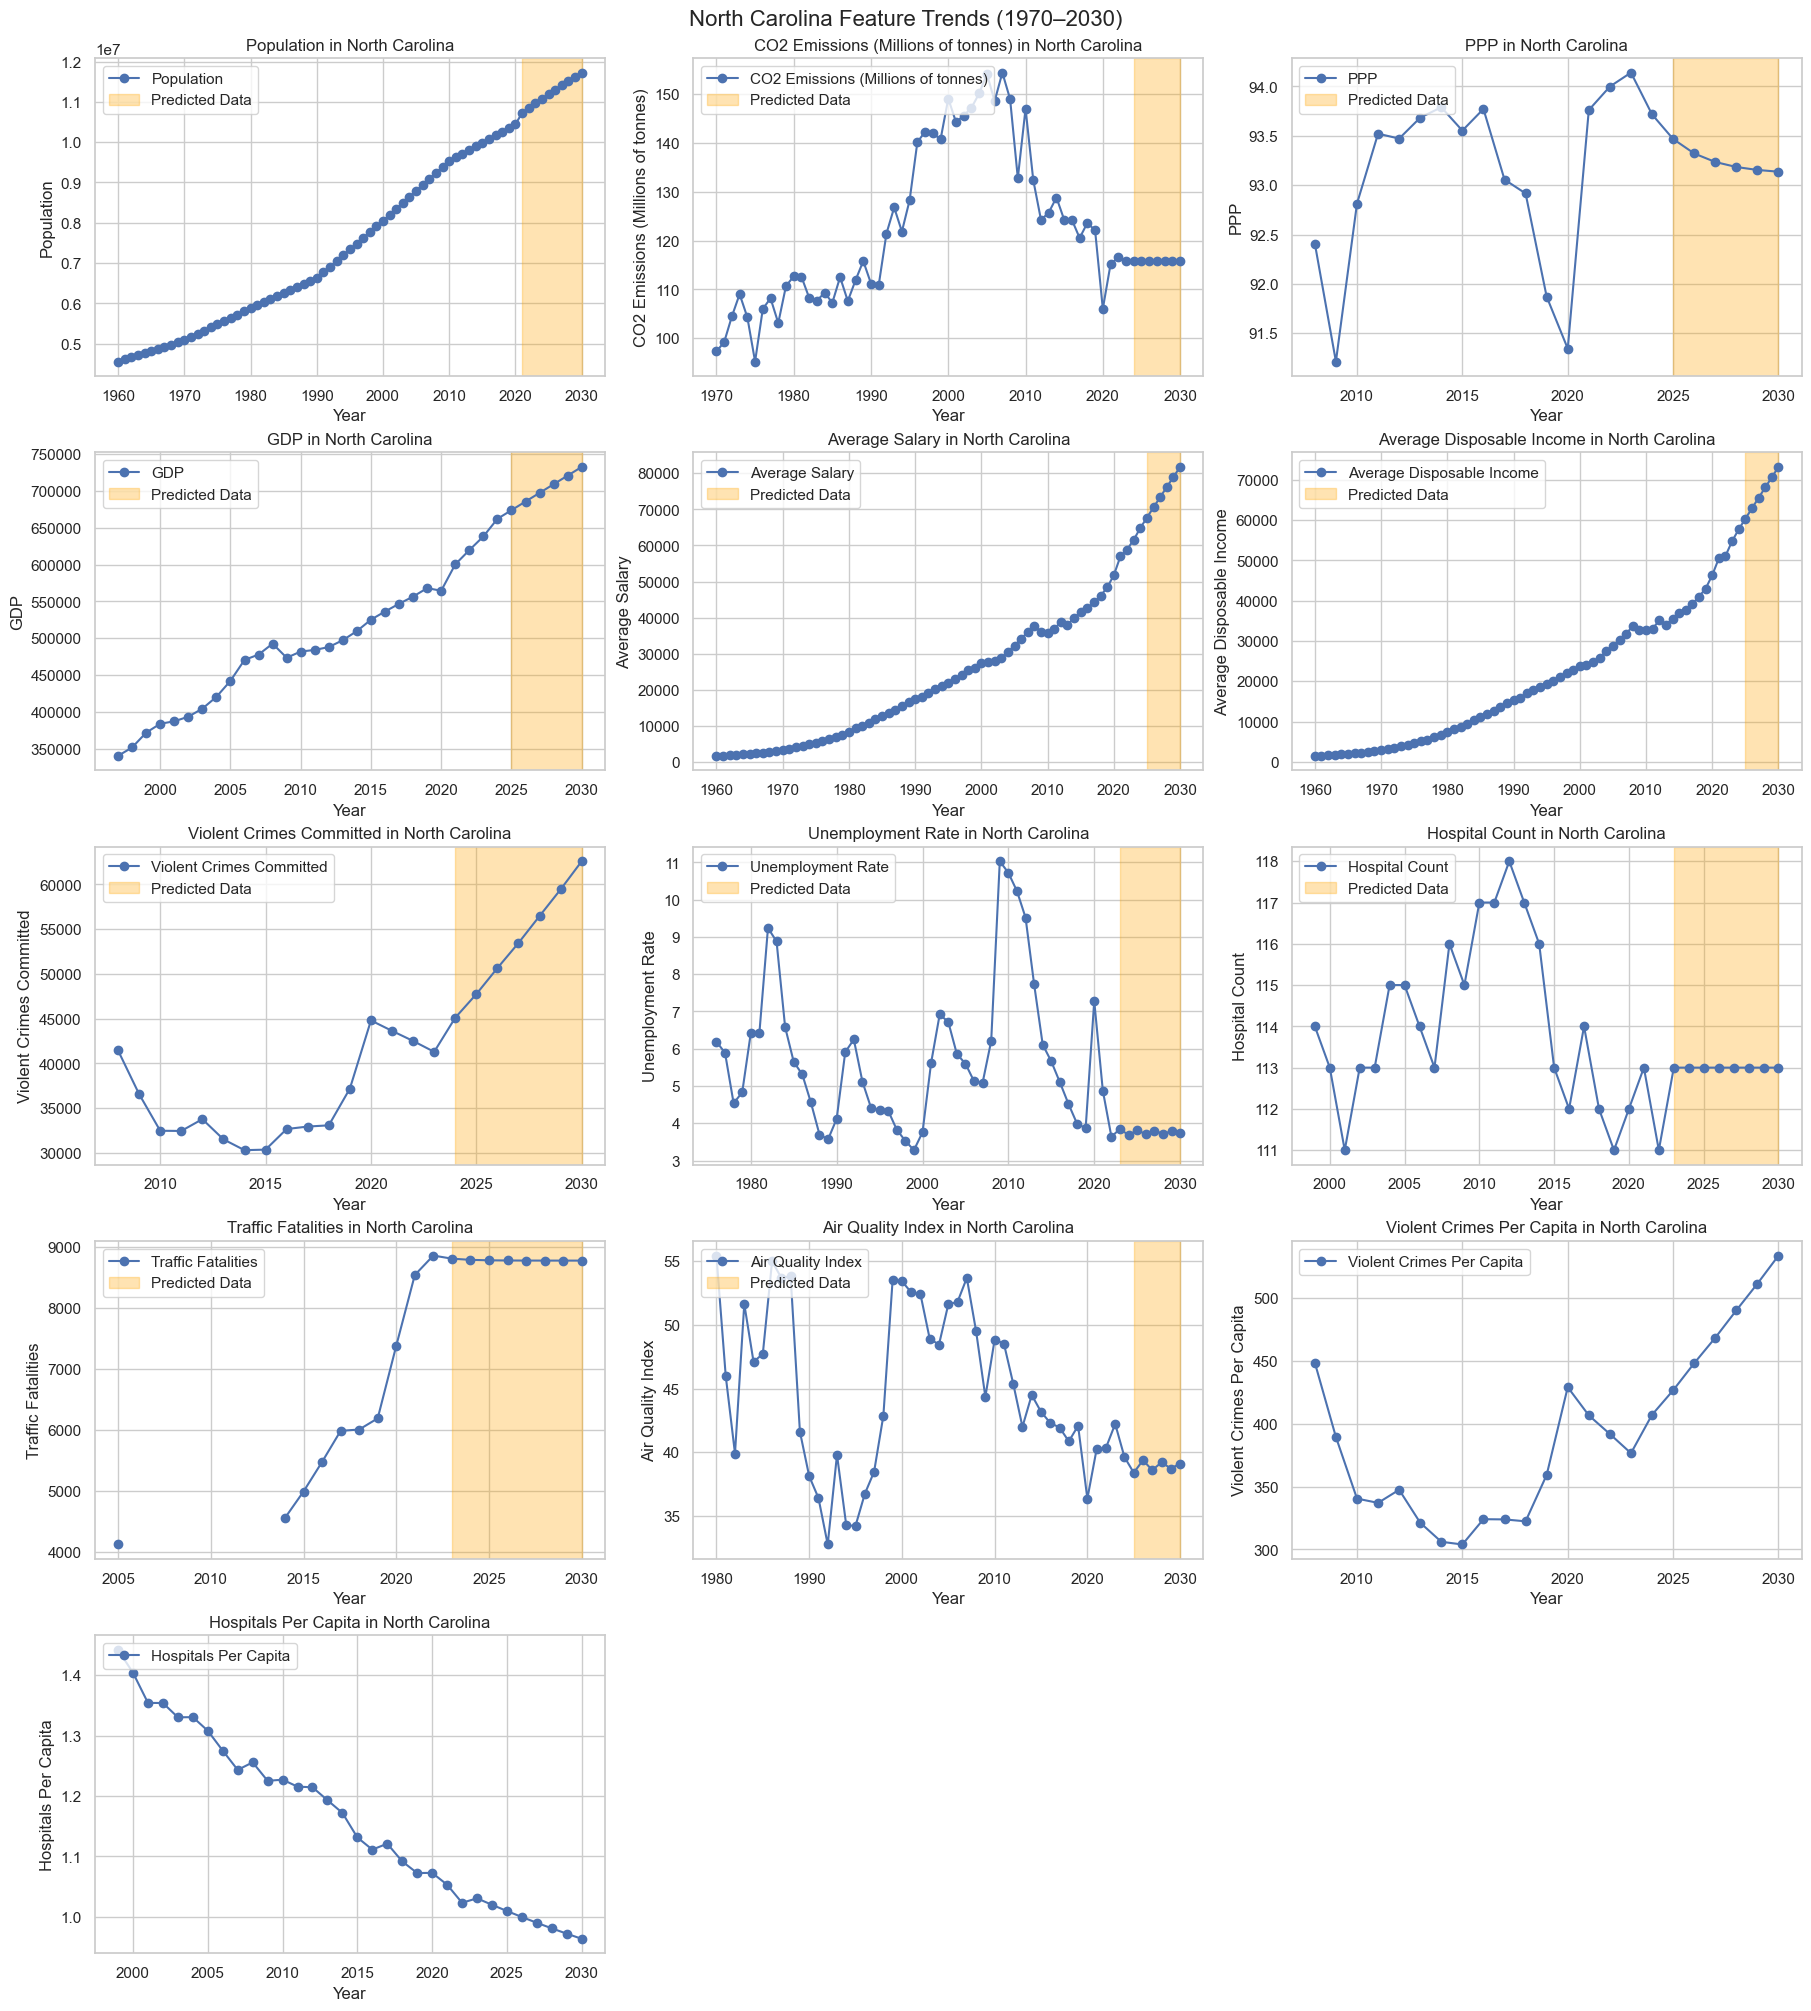

In [19]:
shading_starts = {
    'Population': 2021,
    'CO2 Emissions (Millions of tonnes)': 2024,
    'PPP': 2025, 
    'GDP': 2025,
    'Average Salary': 2025,
    'Average Disposable Income': 2025,
    'Violent Crimes Committed': 2024,
    'Unemployment Rate': 2023,
    'Hospital Count': 2023,
    'Traffic Fatalities': 2023,
    'Air Quality Index': 2025
}

state = 'North Carolina'

# Filter the STATES DataFrame for that state
state_df = STATES[STATES['State'] == state]

if state_df.empty:
    print(f"No data found for state: {state}")
else:
    # Group by year just in case there are multiple entries per year
    df_grouped = state_df.groupby('Year').mean(numeric_only=True).reset_index()

    # List of features to plot (exclude 'Year')
    features = df_grouped.columns.drop('Year')

    # Setup subplots
    n = len(features)
    rows = (n + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(18, 4 * rows), constrained_layout=True)
    axes = axes.flatten()

    # Plot each feature
    for i, feature in enumerate(features):
        axes[i].plot(df_grouped['Year'], df_grouped[feature], marker='o', label=f"{feature}")
        axes[i].set_title(f"{feature} in {state}")
        axes[i].set_xlabel('Year')
        axes[i].set_ylabel(feature)
        axes[i].grid(True)
        
        # Get the year to start shading based on the feature
        shading_start_year = shading_starts.get(feature, None)
        if shading_start_year:
            # Find the index where the shading starts
            start_index = df_grouped[df_grouped['Year'] >= shading_start_year].index[0]
            axes[i].axvspan(df_grouped['Year'].iloc[start_index], df_grouped['Year'].iloc[-1], 
                            color='orange', alpha=0.3, label='Predicted Data')

        axes[i].legend(loc='upper left')

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'{state} Feature Trends (1970–2030)', fontsize=16)
    plt.savefig('output.png')

c:\Users\bosso\Desktop\final project\func.py:876: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=2)  # Make space for legend


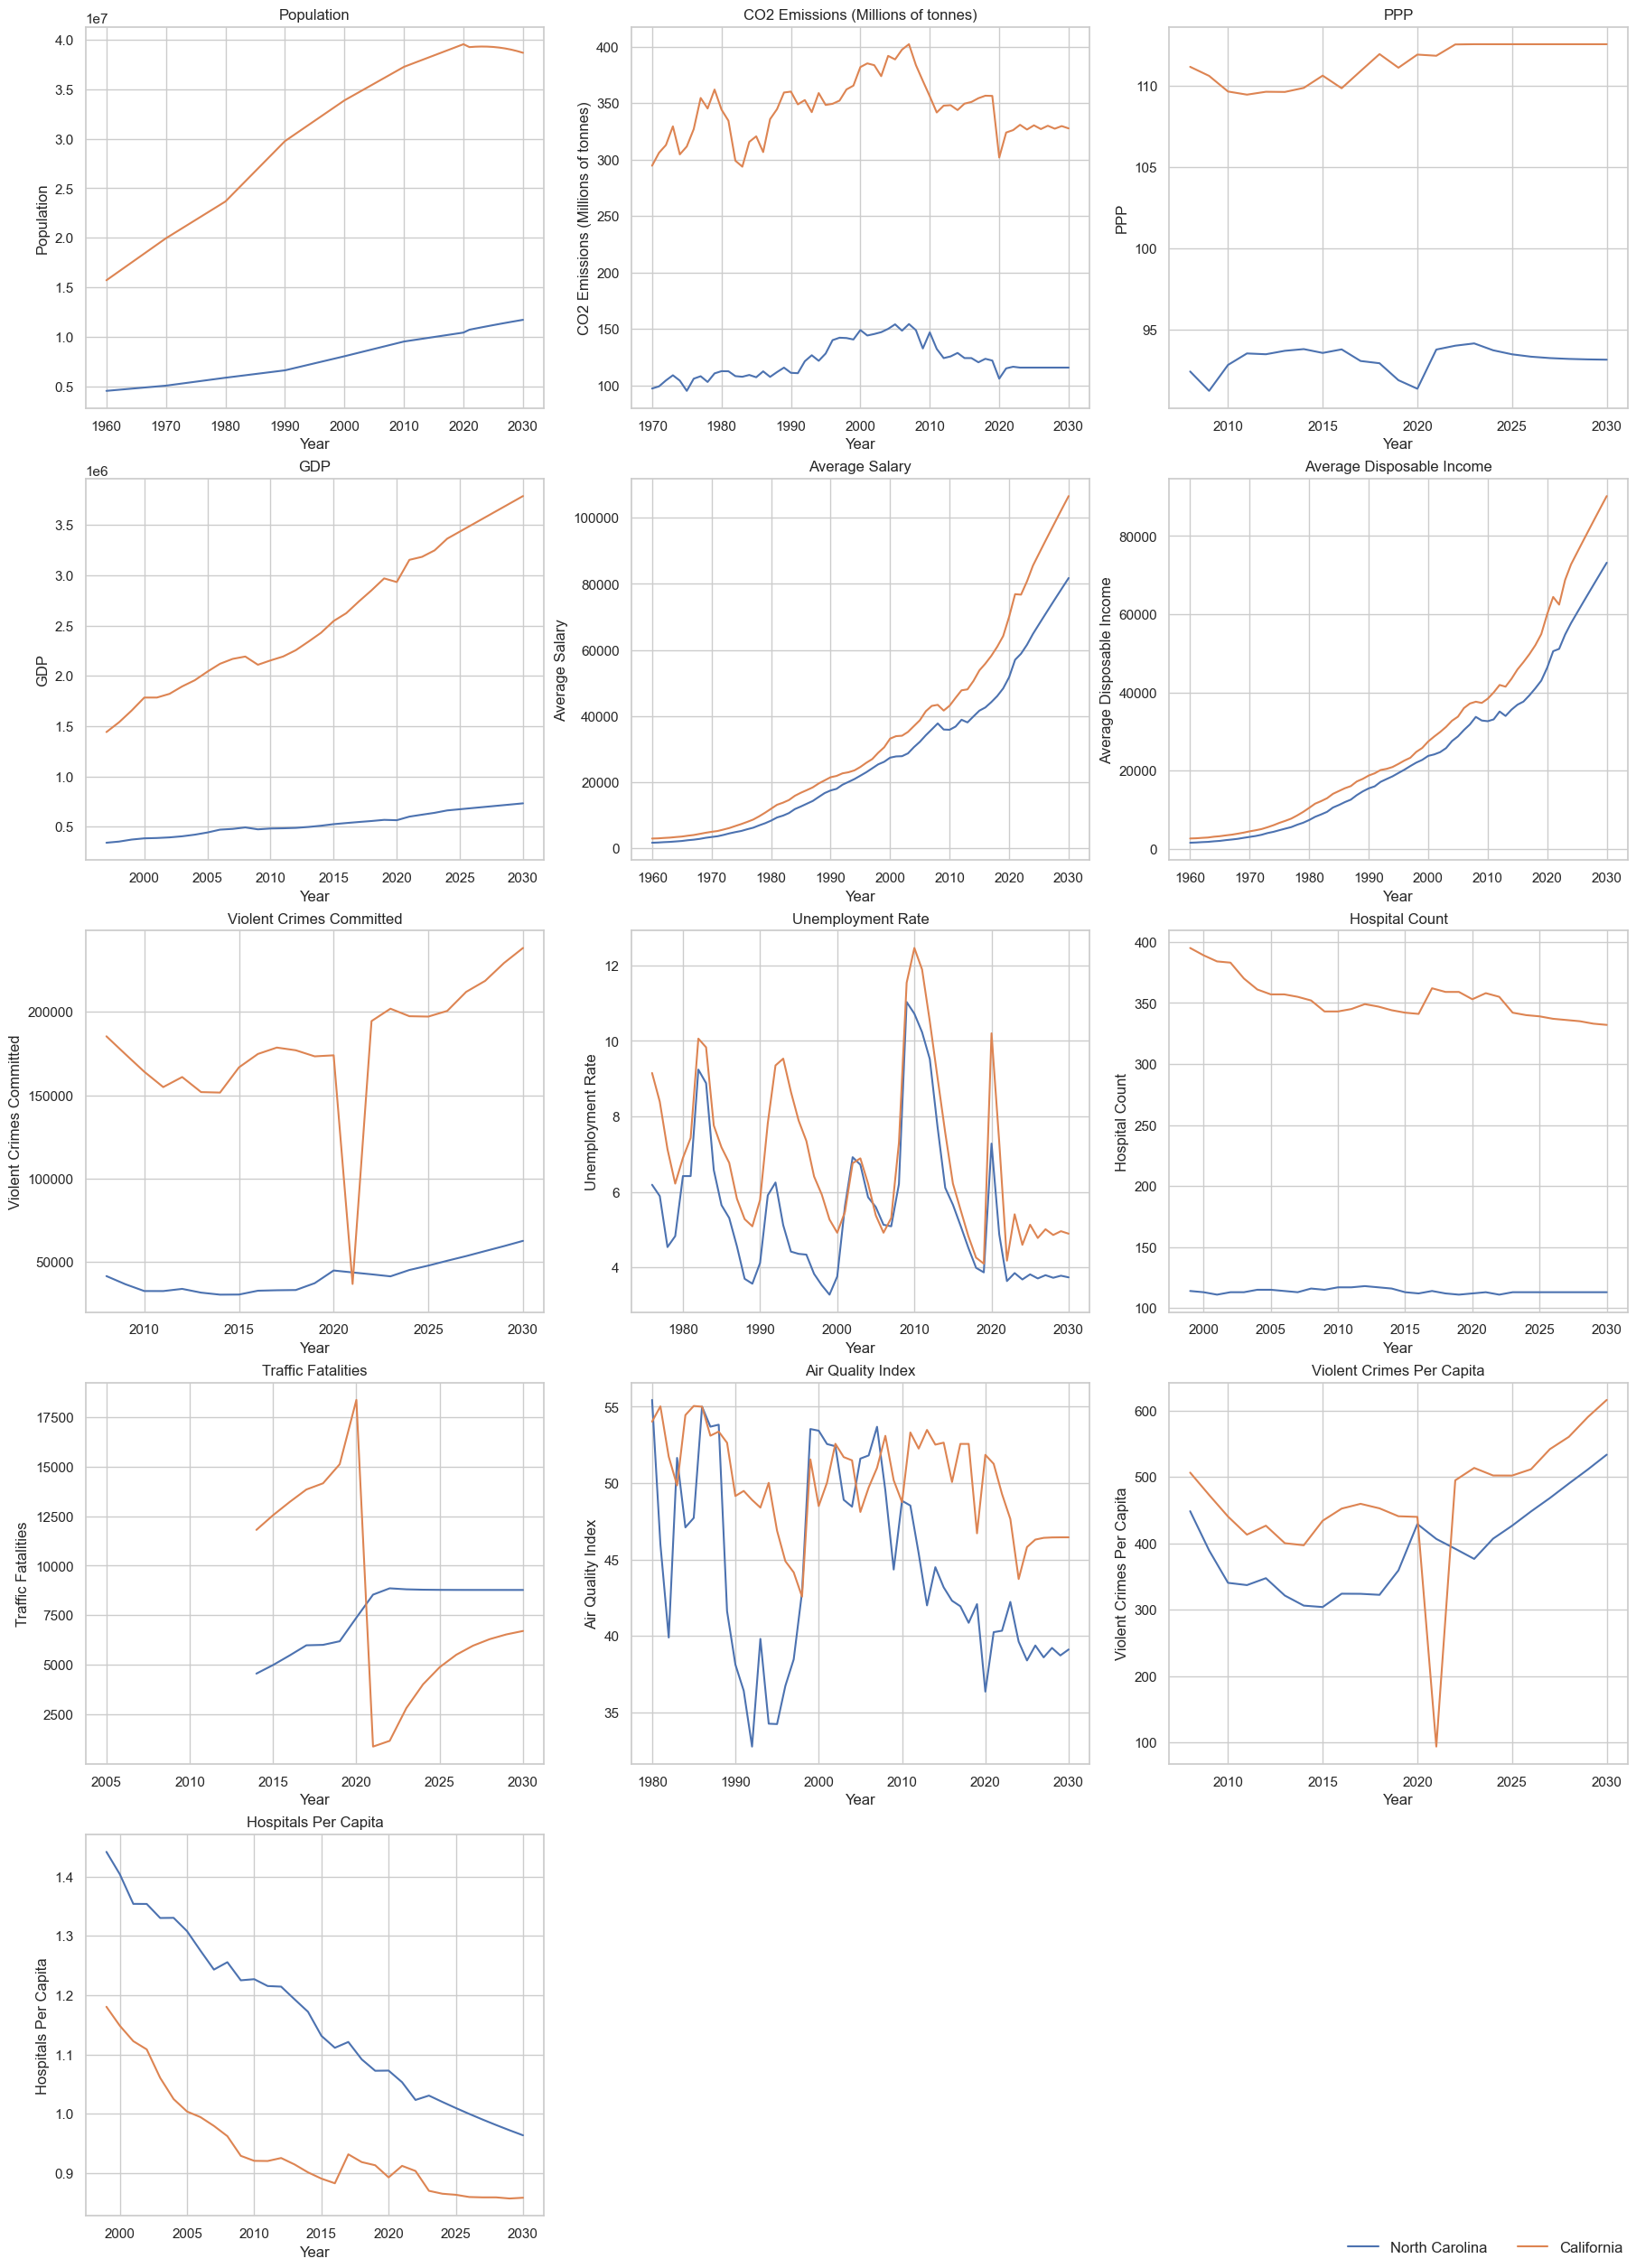

In [20]:
plot_state_group_features(STATES=STATES, selected_states=['North Carolina', 'California'])

In [21]:
data = rank_states(STATES, 2030)
data

,State,Year,Population,CO2 Emissions (Millions of tonnes) Rank,PPP Rank,GDP Rank,Average Salary Rank,Average Disposable Income Rank,Hospitals Per Capita Rank,Unemployment Rate Rank,Traffic Fatalities Rank,Air Quality Index Rank,Violent Crimes Per Capita Rank,Final Score
2058,New Hampshire,2030,1297613,4,7,39,7,6,19,7,10,19,1,119
3549,Wyoming,2030,643619,17,36,49,3,1,4,21,1,13,10,155
1348,Maine,2030,1303927,5,22,42,21,17,14,8,14,12,5,160
1916,Nebraska,2030,2192001,15,38,34,20,19,6,1,9,7,15,164
3194,Vermont,2030,618381,1,18,50,18,16,15,17,7,8,28,178
1632,Minnesota,2030,6156012,29,19,20,12,14,21,10,24,11,18,178
496,Connecticut,2030,3868218,10,9,24,2,2,48,39,19,24,2,179
425,Colorado,2030,6588781,31,13,15,8,5,27,13,27,25,26,190
2910,South Dakota,2030,984033,6,48,47,13,12,1,14,3,10,40,194
141,Alaska,2030,669515,13,12,48,16,11,10,47,4,1,33,195


In [22]:
STATES.columns[3:]

Index(['CO2 Emissions (Millions of tonnes)', 'PPP', 'GDP', 'Average Salary',
       'Average Disposable Income', 'Violent Crimes Committed',
       'Unemployment Rate', 'Hospital Count', 'Traffic Fatalities',
       'Air Quality Index', 'Violent Crimes Per Capita',
       'Hospitals Per Capita'],
      dtype='object')